## Goal 
Our goal is to build a classifier for Radiative Muon Capture event selection (https://ui.adsabs.harvard.edu/abs/2021APS..DNP.FL004M/abstract - https://journals.aps.org/prd/abstract/10.1103/PhysRevD.103.033002) with the Mu2e calorimeter  (https://iopscience.iop.org/article/10.1088/1748-0221/15/09/C09035/pdf), using a custom version of the "lite model' from the ParticleNet Dynamical Graph CNN architecture (https://arxiv.org/abs/1902.08570)

## Dataset
There are three type of samples:
- Photons from Radiative Muon Capture, as signal
- Min-bias events due to the beam, as background
- Cosmic rays, as background

All the samples represent clusters in the upstream calorimeter disk. 

Each sample contains both summary information about the cluster (Energy, Time, Centroid Radius, Number of hits) and hits-level variables (Energy, Time and xy coordinates of each hit).

  ### Model customization
  - In order to help the training:​
    - "summary" vector with Energy, centroid  Radius, Time and Number of active cells, directly sent to the 1st dense layer​​

  - In order to adapt the model to the data:​
      - Last layer changed from softmax to sigmoid, because we have only 2 classes​
      - Number of nearest neighbors changed from 7 to 3, because the clusters are very small

  - In order to reduce overfitting:​
      - Number of edge-conv filters reduced​
      - Number of neurons in 1st dense layer reduced​
      - Dropout rate in 1st dense layer increased​

Original model: https://github.com/hqucms/ParticleNet/blob/master/tf-keras/tf_keras_model.py

## Code

In [32]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [33]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

Data are imported in .npy format from Dropbox 

In [34]:
!wget https://www.dropbox.com/sh/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a?dl=1 -O keras_input.zip
!unzip keras_input.zip

data_folder = "."

--2022-07-07 21:48:44--  https://www.dropbox.com/sh/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a [following]
--2022-07-07 21:48:44--  https://www.dropbox.com/sh/dl/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc653988a275b9e3e8924cb42e37.dl.dropboxusercontent.com/zip_download_get/BMAUSfMx3VrzODo1QbKWfs4tGBc2tLyOhr4U32cterlZ98LJXJxH4WKwU81a16wsM-vr889gtbmElp_6Ysn9aTkjdw5FVEfh59F9jlmWKI_W9g?dl=1# [following]
--2022-07-07 21:48:45--  https://uc653988a275b9e3e8924cb42e37.dl.dropboxusercontent.com/zip_download_get/BMAUSfMx3VrzODo1QbKWfs4tGBc2tLyOhr4U32cterlZ98LJXJxH4WKwU81a16wsM-vr889gtb

The three datasets are saved as dictionaries with 4 components:
-  "points": Point Cloud (xy coordinates of each hit of a cluster) - padded to 50 maximum hits
-  "features": Energy and Time of each hit of a cluster - paddes to 50 maximum hits
-  "mask": Mask to distinguish real hits (the others are filled with 0) in a cluster
-  "summary": Energy, Time, centroid Radius, and Number of active cells for a cluster

In [81]:
name_map = {"points": "xy", "features": "et", "mask": "mask", "summary": "etrn"}

signal  = {key: np.load(f"{data_folder}/signal_{ name_map[key]}.npy") for key in name_map}

mnbs    = {key: np.load(f"{data_folder}/mnbs_{   name_map[key]}.npy") for key in name_map}

cosmics = {key: np.load(f"{data_folder}/cosmics_{name_map[key]}.npy") for key in name_map}

#### Data Visualization

Images of calorimeter hits are showed for the three classes of events

10


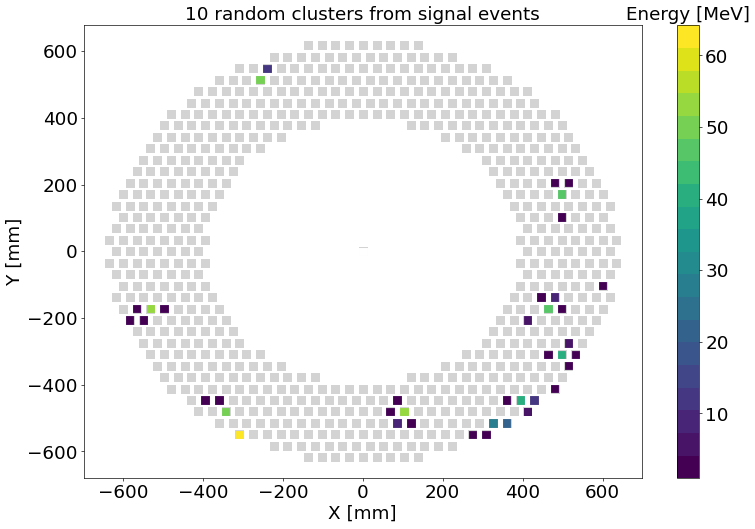

10


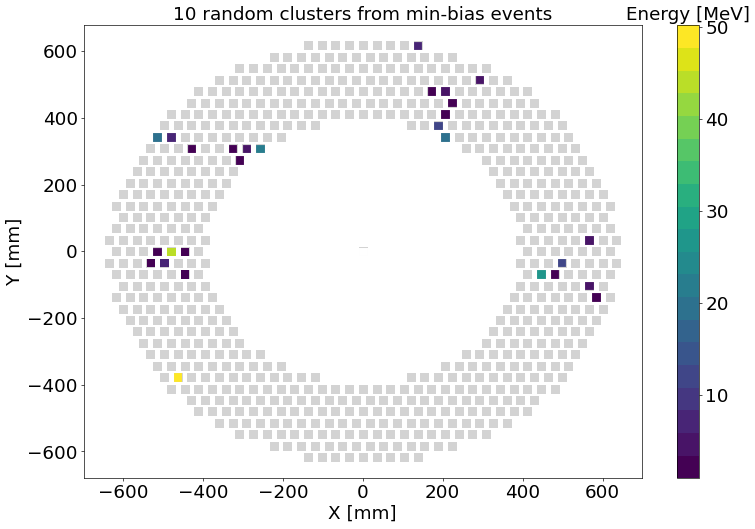

10


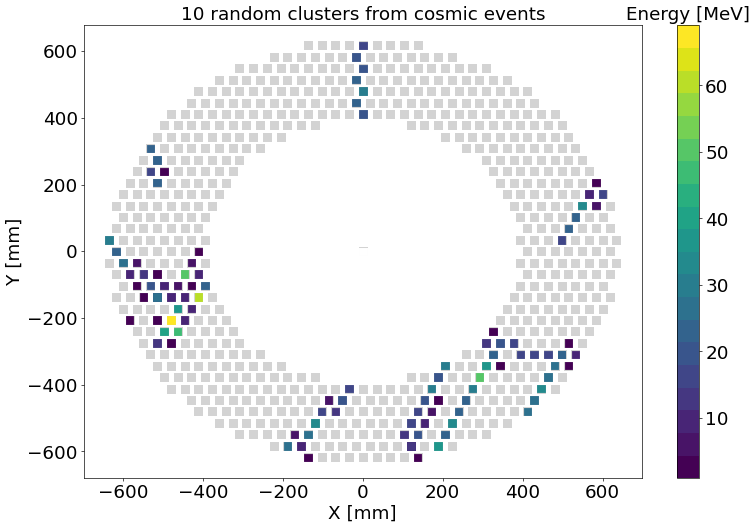

In [36]:
chs = [signal, mnbs, cosmics]
ch_names = ["signal", "min-bias", "cosmic"]

cmap = plt.get_cmap('viridis', 20)
cmap.set_under('white')

N = 10
for ch, name in zip(chs, ch_names):
  evs = np.random.randint(0, high=len(ch["points"]), size=N, dtype=int)
  print(len(evs))
  plt.figure(figsize=(15, 10), dpi=60)
  plt.scatter(cosmics["points"][:, :, 0], cosmics["points"][:, :, 1], marker="s", s=80, color="lightgrey")
  arr_xy = ch["points"][evs]
  x, y = arr_xy[:, :, 0], arr_xy[:, :, 1]
  e = ch["features"][evs][:, :, 0]
  plt.scatter(x, y, c=e, cmap=cmap, vmin=1, marker="s", s=80)
  plt.title(f"{N} random clusters from {name} events", fontsize=22)
  plt.xlabel("X [mm]", fontsize=22)
  plt.ylabel("Y [mm]", fontsize=22)
  plt.xticks(fontsize=22)
  plt.yticks(fontsize=22)
  clb = plt.colorbar()
  clb.ax.set_title('Energy [MeV]',fontsize=22)
  clb.ax.tick_params(labelsize=22)
  plt.show()

#### Training

The datasets (generated with Monte Carlo) are weighted to match the real statistics of the data in one Mu2e injection cycle (1.33 s).


In [37]:
'''
cluster on upstream disk in one injection cycle (1.33s):
RMC: 330
MNBS: 1.3M
cosmici: 4

MC cluster on upstream disk:
RMC: 150k
MNBS: 1.05M
cosmici: 53k

'''

signal_weight = 330/150e3 * 100
mnbs_weight = 0.24 * 100
cosmics_weight = 4/53e3 * 100

'''
the MC has been filtered with ROOT
using two pre-selection cuts:
E > 50 MeV  &&  R > 480 mm
The cuts are necessary because in the low-energy low-radius ragion the 
background due to the beam is huge
'''

print(end="")

The samples are merged into a unique dataset, which is then shuffled, saving also labels and weights

In [38]:
S =  signal["mask"].shape[0] 
F =    mnbs["mask"].shape[0] 
C = cosmics["mask"].shape[0]

N = S + F + C

p = np.random.permutation(N) 

In [82]:
data = {key: np.concatenate( (signal[key], mnbs[key], cosmics[key]) )[p] for key in name_map}

label_list = [1, 0, 0]
entries_list = [S, F, C]
weight_list = [signal_weight, mnbs_weight, cosmics_weight]

print(f"- Entries per signale, mnbs e cosmici:{entries_list}")
print(f"- Pesi per signale, mnbs e cosmici:{weight_list}")

label = np.concatenate( 
    [ np.ones((e))*l for e, l in zip(entries_list,  label_list) ]
)[p]

sample_weight = np.concatenate( 
    [ np.ones((e))*w for e, w in zip(entries_list, weight_list) ]
)[p]

- Entries per signale, mnbs e cosmici:[41372, 1132, 41598]
- Pesi per signale, mnbs e cosmici:[0.22, 24.0, 0.007547169811320755]


The data are normalized to help the training 

In [83]:
from sklearn.preprocessing import StandardScaler
import copy
scaler = StandardScaler()

virgin_data = copy.deepcopy(data)

for key in ["points", "features"]:
  data[key][data["mask"].reshape(N, 50)] = scaler.fit_transform(data[key][data["mask"].reshape(N, 50)])

data["summary"] = scaler.fit_transform(data["summary"])

The dataset is split in training, validation and test set, with a 7:2:1 ratio 

In [84]:
train_data  = {key: data[key][int(N*0.0) : int(N*0.7)] for key in name_map}
test_data   = {key: data[key][int(N*0.7) : int(N*0.9)] for key in name_map}
val_data    = {key: data[key][int(N*0.9) : int(N*1.0)] for key in name_map}

train_label = label[int(N*0.0) : int(N*0.7)]
test_label  = label[int(N*0.7) : int(N*0.9)]
val_label   = label[int(N*0.9) : int(N*1.0)]

train_weight = sample_weight[int(N*0.0) : int(N*0.7)]
test_weight  = sample_weight[int(N*0.7) : int(N*0.9)]
val_weight   = sample_weight[int(N*0.9) : int(N*1.0)]

The custom keras model is imported from our github repo 

In [42]:
# downloading custom particle_net_lite keras model from out github repo
!wget https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/tf_keras_model.py -O tf_keras_model.py

import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net_lite_custom

--2022-07-07 21:49:54--  https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/tf_keras_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6767 (6.6K) [text/plain]
Saving to: ‘tf_keras_model.py’

tf_keras_model.py   100%[===================>]   6.61K  --.-KB/s    in 0s      

2022-07-07 21:49:55 (75.5 MB/s) - ‘tf_keras_model.py’ saved [6767/6767]



In [56]:
input_shapes = {'points': (50, 2), 'features': (50, 2), 'mask':(50, 1)}

model = get_particle_net_lite_custom(input_shapes)

In [57]:
# Training parameters
batch_size = 1024
epochs = 30

The learning rate is exponentially decreased by a 0.1 factor every 10 epochs,
for a maximum of 30 epochs. The best initial learning rate was estimated using the learning rate finder technique (https://colab.research.google.com/github/sachinruk/blog/blob/master/_notebooks/2021-02-15-Tensorflow-Learning-Rate-Finder.ipynb)

In [58]:
# original particle_net learning rate schedule
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

The model is compiled with:
- Loss: Binary crossentropy
- Metric: Area under the Precision Recall curve (AURPC)
- Optimizer: Adam

The loss and the metric are weighted to match the real statistics

In [59]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              weighted_metrics=[keras.metrics.AUC(curve="PR")],
)
model.summary()

[2022-07-07 21:56:21,131] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 50, 1)]      0           []                               
                                                                                                  
 tf.math.not_equal_2 (TFOpLambd  (None, 50, 1)       0           ['mask[0][0]']                   
 a)                                                                                               
                                                                                                  
 tf.cast_4 (TFOpLambda)         (None, 50, 1)        0           ['tf.math.not_equal_2[0][0]']    
                                                                                                  
 tf.math.equal_2 (TFOpLambda)   (None, 50, 1)        0           ['tf.cast_4[0][0]']    

Keras checkpoints are employed to save the model with the best validation AURPC

In [60]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = '%s_model-{val_auc:0.2f}-{epoch:03d}.h5' % "lite"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_auc',
                             verbose=1,
                            )

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, progress_bar, lr_scheduler]

The model is trained, weighting the data to match the real statistics, by means of the sample_weight attribute (for the training).
Also the validation set is weighted, in order to select the model with the best performances on the real statistics.

In [63]:
history = model.fit(
    [train_data["points"], train_data["features"], train_data["mask"], train_data["summary"]], 
    train_label,
    batch_size=batch_size,
    epochs=15,
    validation_data=([val_data["points"], val_data["features"], val_data["mask"], val_data["summary"]], val_label, val_weight),
    shuffle=True,
    sample_weight=train_weight,
    #callbacks=callbacks
)

Epoch 1/15
58/58 [==============================] - 9s 159ms/step - loss: 0.1099 - auc_2: 0.8729 - val_loss: 0.1778 - val_auc_2: 0.7672
Epoch 2/15
58/58 [==============================] - 9s 161ms/step - loss: 0.0889 - auc_2: 0.9136 - val_loss: 0.1652 - val_auc_2: 0.7917
Epoch 3/15
58/58 [==============================] - 9s 162ms/step - loss: 0.0774 - auc_2: 0.9319 - val_loss: 0.1347 - val_auc_2: 0.8474
Epoch 4/15
58/58 [==============================] - 9s 162ms/step - loss: 0.0716 - auc_2: 0.9399 - val_loss: 0.1038 - val_auc_2: 0.8970
Epoch 5/15
58/58 [==============================] - 9s 161ms/step - loss: 0.0686 - auc_2: 0.9463 - val_loss: 0.0892 - val_auc_2: 0.9221
Epoch 6/15
58/58 [==============================] - 9s 160ms/step - loss: 0.0630 - auc_2: 0.9545 - val_loss: 0.0727 - val_auc_2: 0.9434
Epoch 7/15
58/58 [==============================] - 9s 161ms/step - loss: 0.0611 - auc_2: 0.9576 - val_loss: 0.0739 - val_auc_2: 0.9479
Epoch 8/15
58/58 [==============================

In [ ]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()

In [ ]:
plt.plot(history.history['auc'], label="Train AUPRC")
plt.plot(history.history['val_auc'], label="Validation AURPC")
plt.legend()

The network weights from best model are loaded


In [ ]:
# unfortunately we were not able to use save_best_only=True in ModelCheckpoint
# so we are using a workaround to select the model with the best val_auc
! ls -1 model_checkpoints/*model*.h5 | sort -n | tail -n 1
!cp $(ls -1 model_checkpoints/*model*.h5 | sort -n | tail -n 1) model_checkpoints/last.h5

In [ ]:
model.load_weights("model_checkpoints/last.h5")

Prediction probabilities are evaluated on the test set

In [79]:
probs = model.predict_on_batch(test_data)

Precision-recalll curve is plotted and weighted AURPC is calculated

0.9838633843336997


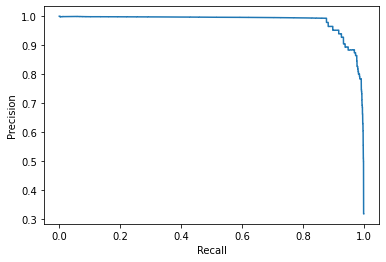

In [86]:
precision, recall, thresholds = precision_recall_curve(test_label, probs, sample_weight=test_weight)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
print(auc(recall, precision))

In [67]:
test_data

{'features': array([[[ 1.31016977, -1.11112754],
         [ 0.67206725, -1.11187643],
         [ 0.51008005, -1.11253301],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.40908446,  1.4413959 ],
         [ 0.25415026,  1.44420437],
         [ 0.21883467,  1.44225899],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.90036026, -0.19134283],
         [ 0.62924027, -0.19158887],
         [ 0.59687364, -0.19157069],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        ...,
 
        [[ 1.30267523,  0.06206795],
         [ 1.06644627,  0.06145126],
         [ 0.70190986,  0.05870527],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 2.9543

In [87]:
bin = model.predict(test_data)

(array([5.44873251e+01, 8.69295973e+01, 4.22663782e+01, 1.10606711e+01,
        3.07184428e+01, 4.88239414e+00, 5.47987568e+00, 7.82707962e+00,
        3.65253377e+00, 4.85258911e+00, 3.57661796e+00, 7.10565088e-01,
        1.06478499e+00, 1.99004340e+00, 1.51781140e-01, 1.81160546e-01,
        2.17998718e-01, 1.00092594e+00, 2.07026478e-01, 1.61935037e-01,
        1.28439297e-01, 1.93918866e-01, 1.26605373e+01, 2.12986105e-01,
        1.42990004e-01, 1.66674470e-01, 7.65389934e-01, 1.43595289e+01,
        2.48464860e-01, 2.33216918e-01, 1.33751220e-01, 1.53573824e-01,
        1.75878551e-01, 8.65983081e-02, 1.83885298e-01, 1.83139855e-01,
        1.19141762e-01, 2.00291940e-01, 1.43941527e-01, 1.71992214e-01,
        7.42119894e-02, 1.44020200e-01, 1.52953705e-01, 1.84544337e-01,
        1.49845306e-01, 1.66344400e-01, 1.63562233e-01, 1.58368380e-01,
        1.29482928e-01, 1.09117140e-01]),
 array([ 50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
         61.,  62., 

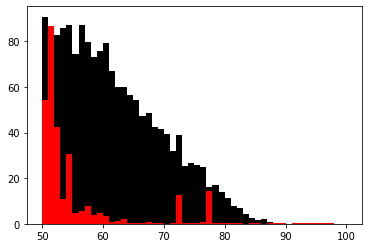

In [97]:
bin_sig = bin[test_label == 1][:, 0]
bin_bkg = bin[test_label == 0][:, 0]
weight_sig = test_weight[test_label == 1]
weight_bkg = test_weight[test_label == 0]

test_virgin_data = {key: virgin_data[key][int(N*0.7) : int(N*0.9)] for key in name_map}

en = test_virgin_data["summary"][:, 0]
en_sig = en[test_label == 1]
en_bkg = en[test_label == 0]

plt.hist(en_sig, range=(50, 100), bins=50, weights=weight_sig * bin_sig, color="black")
plt.hist(en_bkg, range=(50, 100), bins=50, weights=weight_bkg * bin_bkg, color="red")